In [1]:
from pathlib import Path
import shutil

DATA_ROOT = Path("./tpdne_faces")
assert DATA_ROOT.exists(), f"{DATA_ROOT} does not exist"

# create subfolder if none exist
subdirs = [p for p in DATA_ROOT.iterdir() if p.is_dir()]
if len(subdirs) == 0:
    faces_dir = DATA_ROOT / "faces"
    faces_dir.mkdir(exist_ok=True)
    moved = 0
    for p in DATA_ROOT.iterdir():
        if p.is_file() and p.suffix.lower() in {".jpg", ".jpeg", ".png", ".webp"}:
            shutil.move(str(p), str(faces_dir / p.name))
            moved += 1
    print(f"Moved {moved} files into {faces_dir}")
else:
    print("Found subfolders, not moving anything:", [d.name for d in subdirs])


Found subfolders, not moving anything: ['faces']


In [2]:
import os
from pathlib import Path
import random
import math
import itertools
import imageio.v2 as imageio

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils as vutils

import matplotlib.pyplot as plt
from tqdm import tqdm

print(torch.__version__)

# ===== Reproducibility =====
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# ===== Device (CUDA / Apple MPS / CPU) =====
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():  # for Apple Silicon / Metal
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

# ===== Paths =====

from pathlib import Path
DATA_ROOT = Path("./tpdne_faces")  # change to your local folder
assert DATA_ROOT.exists(), f"{DATA_ROOT} does not exist"

# DATA_ROOT = "./tpdne_faces"
RUN_DIR   = Path("dcgan_run_v31")
SAMPLES   = RUN_DIR / "samples"
CKPTS     = RUN_DIR / "checkpoints"
for p in [RUN_DIR, SAMPLES, CKPTS]:
    p.mkdir(parents=True, exist_ok=True)

# ===== DCGAN Hyperparams =====
image_size   = 64       # 64x64 RGB
nc           = 3        # number of channels
nz           = 100      # latent vector size
ngf          = 64       # base feature maps in G
ndf          = 64       # base feature maps in D
batch_size   = 128
num_workers  = 2

# Training
num_epochs   = 150      # >= 50 recommended; 150 better if time allows
lr           = 2e-4
beta1        = 0.5      # DCGAN recommended
beta2        = 0.999

# Logging / sampling
fixed_noise  = torch.randn(64, nz, 1, 1, device=device)  # 64-sample fixed noise
save_every   = 1   # save samples every epoch
ckpt_every   = 10  # save checkpoint every N epochs

print("Config OK")


2.9.0
Using device: mps
Config OK


In [3]:
# Images normalized to [-1, 1] as per DCGAN best practices
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*nc, [0.5]*nc),
])

# Expecting structure: DATA_ROOT/<any_class_name>/*.jpg
# If your images are all in one folder, create a subfolder and put them inside.
dataset = datasets.ImageFolder(root=DATA_ROOT, transform=transform)
assert len(dataset) > 0, "Dataset is empty. Check DATA_ROOT and folder structure."

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=torch.cuda.is_available()
)

len(dataset), len(dataloader)


(1011, 8)

In [4]:
# Weight initialization from the DCGAN paper
def weights_init(m):
    classname = m.__class__.__name__
    if "Conv" in classname:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif "BatchNorm" in classname:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.zeros_(m.bias.data)

class Generator(nn.Module):
    """
    Input: Z ~ N(0,1), shape (N, nz, 1, 1)
    Output: fake image in [-1, 1], shape (N, 3, 64, 64)
    """
    def __init__(self, nz=100, ngf=64, nc=3):
        super().__init__()
        self.main = nn.Sequential(
            # (nz) x 1 x 1 -> (ngf*8) x 4 x 4
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),

            # (ngf*8) x 4 x 4 -> (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),

            # (ngf*4) x 8 x 8 -> (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),

            # (ngf*2) x 16 x 16 -> (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            # (ngf) x 32 x 32 -> (nc) x 64 x 64
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.main(z)

class Discriminator(nn.Module):
    """
    Input: image in [-1, 1], shape (N, 3, 64, 64)
    Output: scalar logit (N, 1, 1, 1) indicating real/fake
    """
    def __init__(self, ndf=64, nc=3):
        super().__init__()
        self.main = nn.Sequential(
            # (nc) x 64 x 64 -> (ndf) x 32 x 32
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # (ndf) x 32 x 32 -> (ndf*2) x 16 x 16
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),

            # (ndf*2) x 16 x 16 -> (ndf*4) x 8 x 8
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),

            # (ndf*4) x 8 x 8 -> (ndf*8) x 4 x 4
            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),

            # (ndf*8) x 4 x 4 -> 1 x 1 x 1
            nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False)
            # No Sigmoid here; we'll use BCEWithLogitsLoss
        )

    def forward(self, x):
        return self.main(x).view(-1)  # flatten to (N,)


In [5]:
netG = Generator(nz=nz, ngf=ngf, nc=nc).to(device)
netD = Discriminator(ndf=ndf, nc=nc).to(device)

netG.apply(weights_init)
netD.apply(weights_init)

print(netG)
print(netD)

criterion = nn.BCEWithLogitsLoss()

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, beta2))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, beta2))


Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [6]:
def save_sample_grid(tensor_bchw, path, nrow=8):
    # Denormalize from [-1,1] to [0,1] for saving
    grid = vutils.make_grid((tensor_bchw + 1) / 2, nrow=nrow, padding=2)
    vutils.save_image(grid, path)

G_losses = []
D_losses = []

for epoch in range(1, num_epochs + 1):
    netG.train()
    netD.train()

    running_loss_G = 0.0
    running_loss_D = 0.0
    batches = 0

    pbar = tqdm(dataloader, desc=f"Epoch {epoch}/{num_epochs}", leave=False)
    for real_imgs, _ in pbar:
        batches += 1
        real_imgs = real_imgs.to(device, non_blocking=True)
        bsz = real_imgs.size(0)

        # Real and fake labels
        real_label = torch.ones(bsz, device=device)
        fake_label = torch.zeros(bsz, device=device)

        # =========================
        # 1) Update D: maximize log(D(x)) + log(1 - D(G(z)))
        # =========================
        netD.zero_grad(set_to_none=True)

        # Real
        out_real = netD(real_imgs)
        loss_D_real = criterion(out_real, real_label)

        # Fake
        noise = torch.randn(bsz, nz, 1, 1, device=device)
        fake_imgs = netG(noise).detach()     # detach so G isn't updated here
        out_fake = netD(fake_imgs)
        loss_D_fake = criterion(out_fake, fake_label)

        loss_D = loss_D_real + loss_D_fake
        loss_D.backward()
        optimizerD.step()

        # =========================
        # 2) Update G: maximize log(D(G(z)))  <=> minimize BCEWithLogits(D(G(z)), 1)
        # =========================
        netG.zero_grad(set_to_none=True)
        noise = torch.randn(bsz, nz, 1, 1, device=device)
        gen_imgs = netG(noise)
        out_gen = netD(gen_imgs)
        loss_G = criterion(out_gen, real_label)  # want D to predict real (1)

        loss_G.backward()
        optimizerG.step()

        running_loss_G += loss_G.item()
        running_loss_D += loss_D.item()

        pbar.set_postfix(
            d=f"{loss_D.item():.3f}",
            g=f"{loss_G.item():.3f}"
        )

    epoch_loss_G = running_loss_G / batches
    epoch_loss_D = running_loss_D / batches
    G_losses.append(epoch_loss_G)
    D_losses.append(epoch_loss_D)

    # Save fixed 64-sample grid every epoch
    if (epoch % save_every) == 0:
        netG.eval()
        with torch.no_grad():
            fake_fixed = netG(fixed_noise).cpu()
        save_sample_grid(fake_fixed, SAMPLES / f"epoch_{epoch:04d}.png", nrow=8)

    # Save checkpoint
    if (epoch % ckpt_every) == 0 or epoch == num_epochs:
        torch.save(
            {"epoch": epoch, "netG": netG.state_dict(), "netD": netD.state_dict(),
             "optG": optimizerG.state_dict(), "optD": optimizerD.state_dict(),
             "G_losses": G_losses, "D_losses": D_losses},
            CKPTS / f"dcgan_epoch_{epoch:04d}.pt"
        )

print("Training finished.")


Training finished.


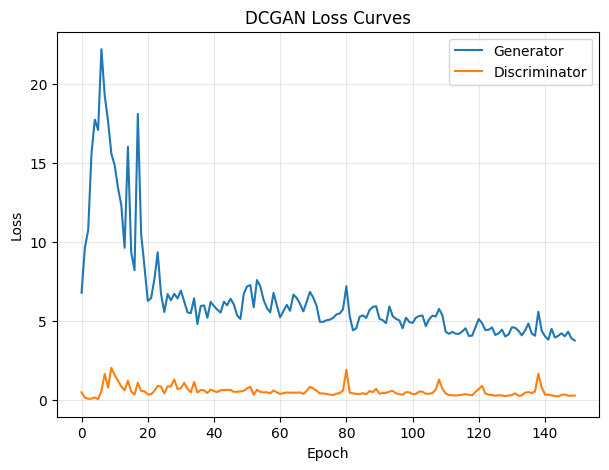

In [7]:
plt.figure(figsize=(7,5))
plt.plot(G_losses, label="Generator")
plt.plot(D_losses, label="Discriminator")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("DCGAN Loss Curves")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Showing epoch_0150.png


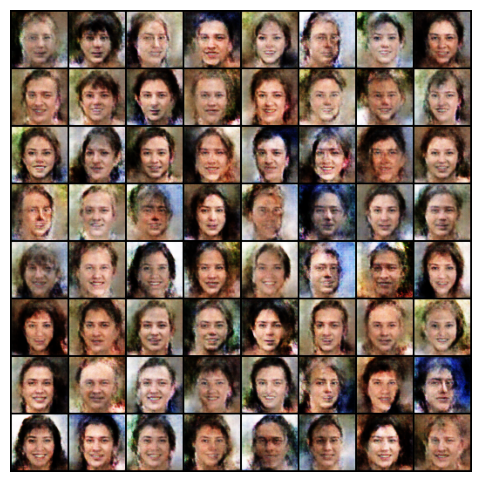

In [8]:
# Show the last saved grid
last_grid = sorted(SAMPLES.glob("epoch_*.png"))[-1]
print(f"Showing {last_grid.name}")
img = imageio.imread(last_grid)
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis("off")
plt.show()


In [9]:
frames = []
pngs = sorted(SAMPLES.glob("epoch_*.png"))
assert len(pngs) > 0, "No sample images found. Train at least 1 epoch."

for p in pngs:
    frames.append(imageio.imread(p))

gif_path = RUN_DIR / "training_progress.gif"
imageio.mimsave(gif_path, frames, duration=0.25)  # 0.25s per frame
gif_path


PosixPath('dcgan_run_v31/training_progress.gif')

In [10]:
netG.eval()
with torch.no_grad():
    z = torch.randn(64, nz, 1, 1, device=device)
    fakes = netG(z).cpu()

grid_path = RUN_DIR / "samples_latest.png"
vutils.save_image((fakes + 1)/2, grid_path, nrow=8)
print(f"Saved: {grid_path}")


Saved: dcgan_run_v31/samples_latest.png
